In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from kmodes.kprototypes import KPrototypes
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv("Sleep_Efficiency.csv")

In [29]:
data.isnull().sum()

ID                         0
Age                        0
Gender                     0
Bedtime                    0
Wakeup time                0
Sleep duration             0
Sleep efficiency           0
REM sleep percentage       0
Deep sleep percentage      0
Light sleep percentage     0
Awakenings                20
Caffeine consumption      25
Alcohol consumption       14
Smoking status             0
Exercise frequency         6
dtype: int64

In [30]:
data["Awakenings"].fillna(0, inplace = True)
data["Caffeine consumption"].fillna(0, inplace = True)
data["Alcohol consumption"].fillna(0, inplace = True)
data["Exercise frequency"].fillna(0, inplace = True)

In [31]:
data.drop('ID',axis=1,inplace=True)
data.drop('Gender',axis=1,inplace=True)
data.drop('Age',axis=1,inplace=True)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Bedtime                 452 non-null    object 
 1   Wakeup time             452 non-null    object 
 2   Sleep duration          452 non-null    float64
 3   Sleep efficiency        452 non-null    float64
 4   REM sleep percentage    452 non-null    int64  
 5   Deep sleep percentage   452 non-null    int64  
 6   Light sleep percentage  452 non-null    int64  
 7   Awakenings              452 non-null    float64
 8   Caffeine consumption    452 non-null    float64
 9   Alcohol consumption     452 non-null    float64
 10  Smoking status          452 non-null    object 
 11  Exercise frequency      452 non-null    float64
dtypes: float64(6), int64(3), object(3)
memory usage: 42.5+ KB


In [33]:
data.rename(columns={'Wakeup time': 'Wakeup_time'}, inplace=True)
data['Bedtime'] = pd.to_datetime(data['Bedtime'])
data['Wakeup_time']  = pd.to_datetime(data['Wakeup_time'])

###get rid of the day, year and month, remain the hour only
data['Bedtime'] = data.Bedtime.apply(lambda x: x.hour)
data['Wakeup_time'] = data.Wakeup_time.apply(lambda x: x.hour)

In [34]:
##smaller values mean waking up earlier
####on the contrary,mean waking up later
data['Wakeup_time'].unique()

array([ 7,  9,  5,  8,  4,  3, 10,  6, 11, 12], dtype=int64)

## data catagorization


In [35]:
#categorize the bedtime, small values mean sleeping early while high vaule mean sleeping later


data.loc[data['Bedtime'] == 21, 'Bedtime'] = 10
data.loc[data['Bedtime'] ==22 , 'Bedtime'] = 20
data.loc[data['Bedtime'] ==23   , 'Bedtime']  = 30
data.loc[data['Bedtime'] ==0 , 'Bedtime'] = 40
data.loc[data['Bedtime'] ==1 , 'Bedtime'] = 50
data.loc[data['Bedtime'] ==2 , 'Bedtime'] = 60

## data exploration and quartile 

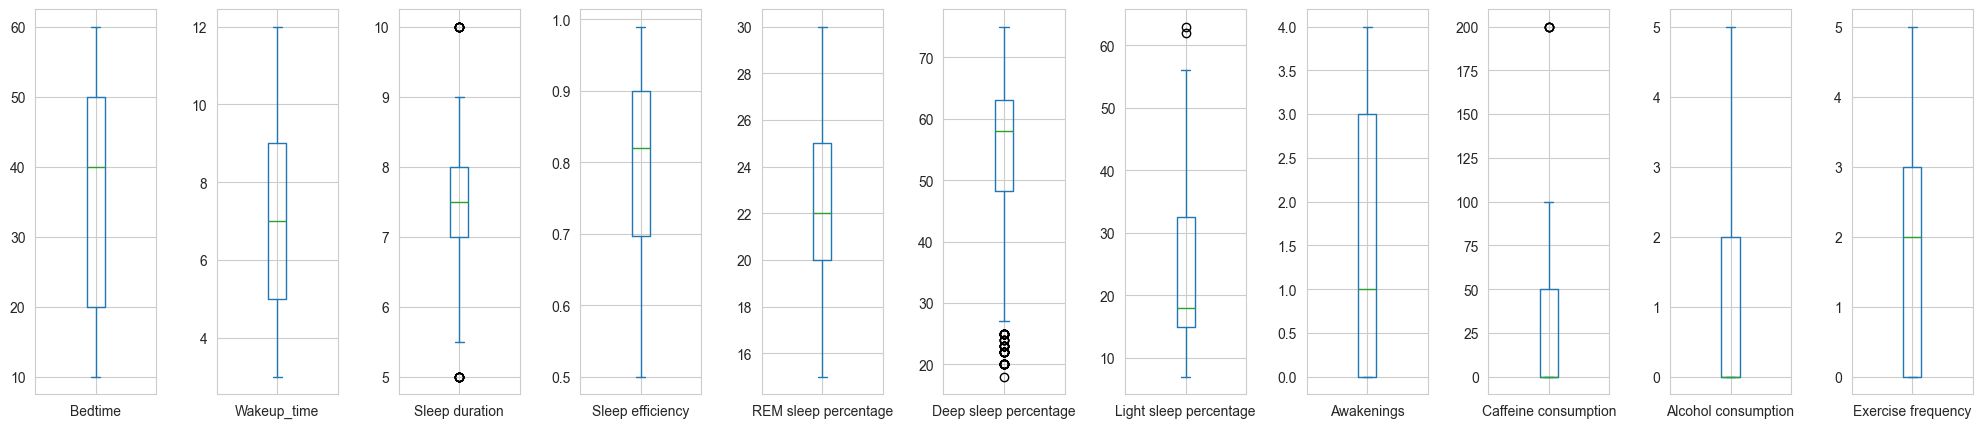

In [36]:
df=data
dfnum=df.select_dtypes('number')
dfnum.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(25, 5)
)

# increase spacing between subplots
plt.subplots_adjust(wspace=0.5) 
plt.show()

In [37]:
# Determine each interval
print('1º Quartile: ', df['Light sleep percentage'].quantile(q = 0.25))
print('3º Quartile: ', df['Light sleep percentage'].quantile(q = 0.75))


#Calculate the outliers:
  # Interquartile range, IQR = Q3 - Q1
  # lower 1.5*IQR whisker = Q1 - 1.5 * IQR 
  # Upper 1.5*IQR whisker = Q3 + 1.5 * IQR    
print('Light sleep percentages above: ', df['Light sleep percentage'].quantile(q = 0.75) + 
                      1.5*(df['Light sleep percentage'].quantile(q = 0.75) - 
                           df['Light sleep percentage'].quantile(q = 0.25)), 'are outliers')

1º Quartile:  15.0
3º Quartile:  32.5
Light sleep percentages above:  58.75 are outliers


In [38]:
# Determine each interval
print('1º Quartile: ', df['Deep sleep percentage'].quantile(q = 0.25))
print('3º Quartile: ', df['Deep sleep percentage'].quantile(q = 0.75))
print('Deep sleep percentage below: ', df['Deep sleep percentage'].quantile(q = 0.25)-1.5*(df['Deep sleep percentage'].quantile(q = 0.75) - 
                           df['Deep sleep percentage'].quantile(q = 0.25)), 'are outliers')

1º Quartile:  48.25
3º Quartile:  63.0
Deep sleep percentage below:  26.125 are outliers


In [39]:
df1=df[(df['Light sleep percentage'] <= 58) & (df['Deep sleep percentage'] >= 27)]

### KPROTO Clustering

In [40]:
# Convert dataframe to matrix
dfMatrix = df1.to_numpy()

In [41]:
# Get the position of categorical columns
catColumnsPos = [df1.columns.get_loc(col) for col in list(df1.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(df1.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['Smoking status']
Categorical columns position  : [10]


In [42]:
# Choose optimal K using Elbow method
cost = []
for cluster in range(1,10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters= cluster, init ='Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
print(cost)

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9
[573207.1742263136, 338141.9433332215, 255554.38650019167, 193792.54953732906, 133914.1240042506, 116590.31456833264, 98810.36757686773, 82044.48023723955, 72291.82493822767]


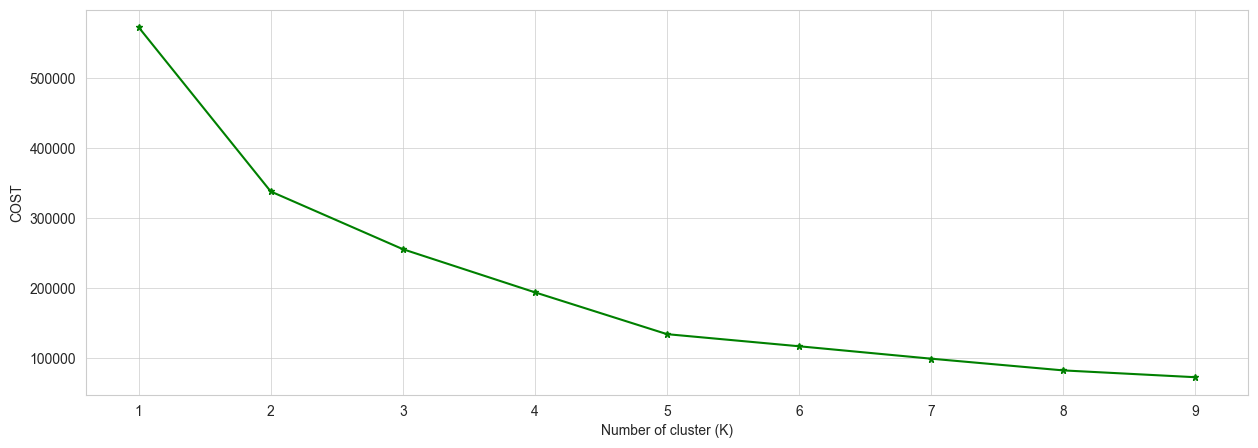

In [43]:
# Plot accuracy values with different K 
plt.figure(figsize=(15,5))

plt.plot(range(1, 10), cost, 'g',marker='*',markersize=5)
plt.grid(linewidth = 0.5)
plt.ylabel('COST')
plt.xlabel('Number of cluster (K)')
plt.show()

In [44]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

array([0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2,
       0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0,
       2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0,
       0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0,
       2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2,

In [45]:
# Add the cluster to the dataframe
df1['Cluster Labels'] = kprototype.labels_
df1['Segment'] = df1['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third'})
# Order the cluster
df1['Segment'] = df1['Segment'].astype('category')
df1['Segment'] = df1['Segment'].cat.reorder_categories(['First','Second','Third'])

### CLuster visualizatiom

In [46]:
num_cols=list(df1.select_dtypes('number').columns)
object_cols=list(df1.select_dtypes('object').columns)

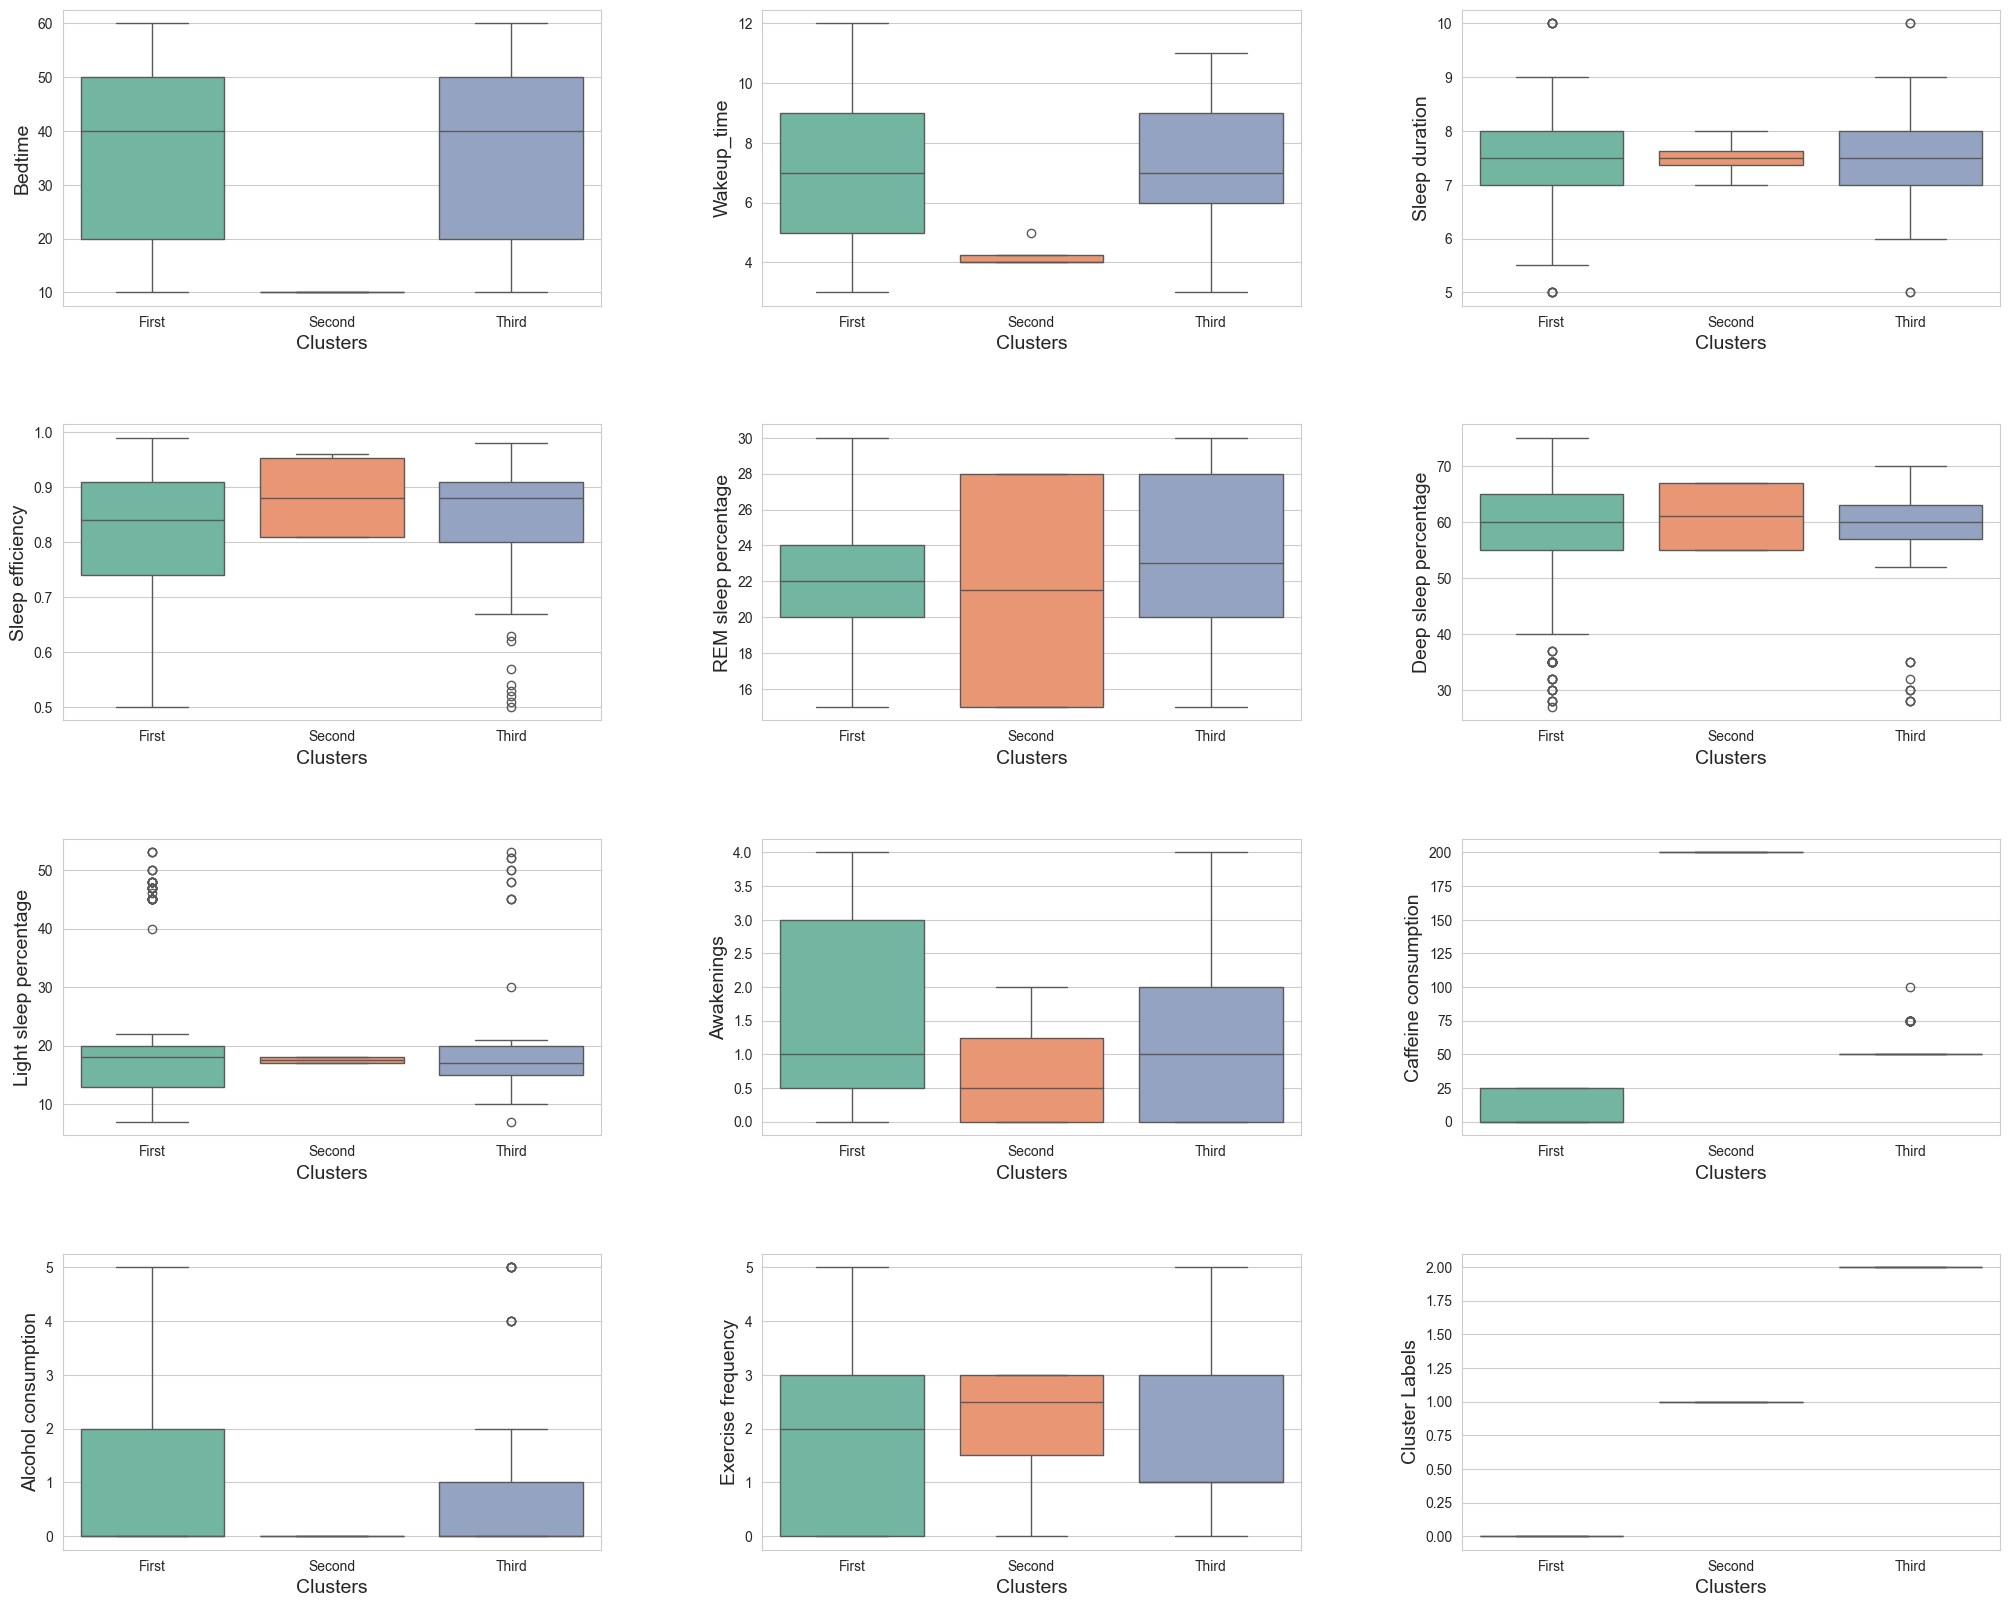

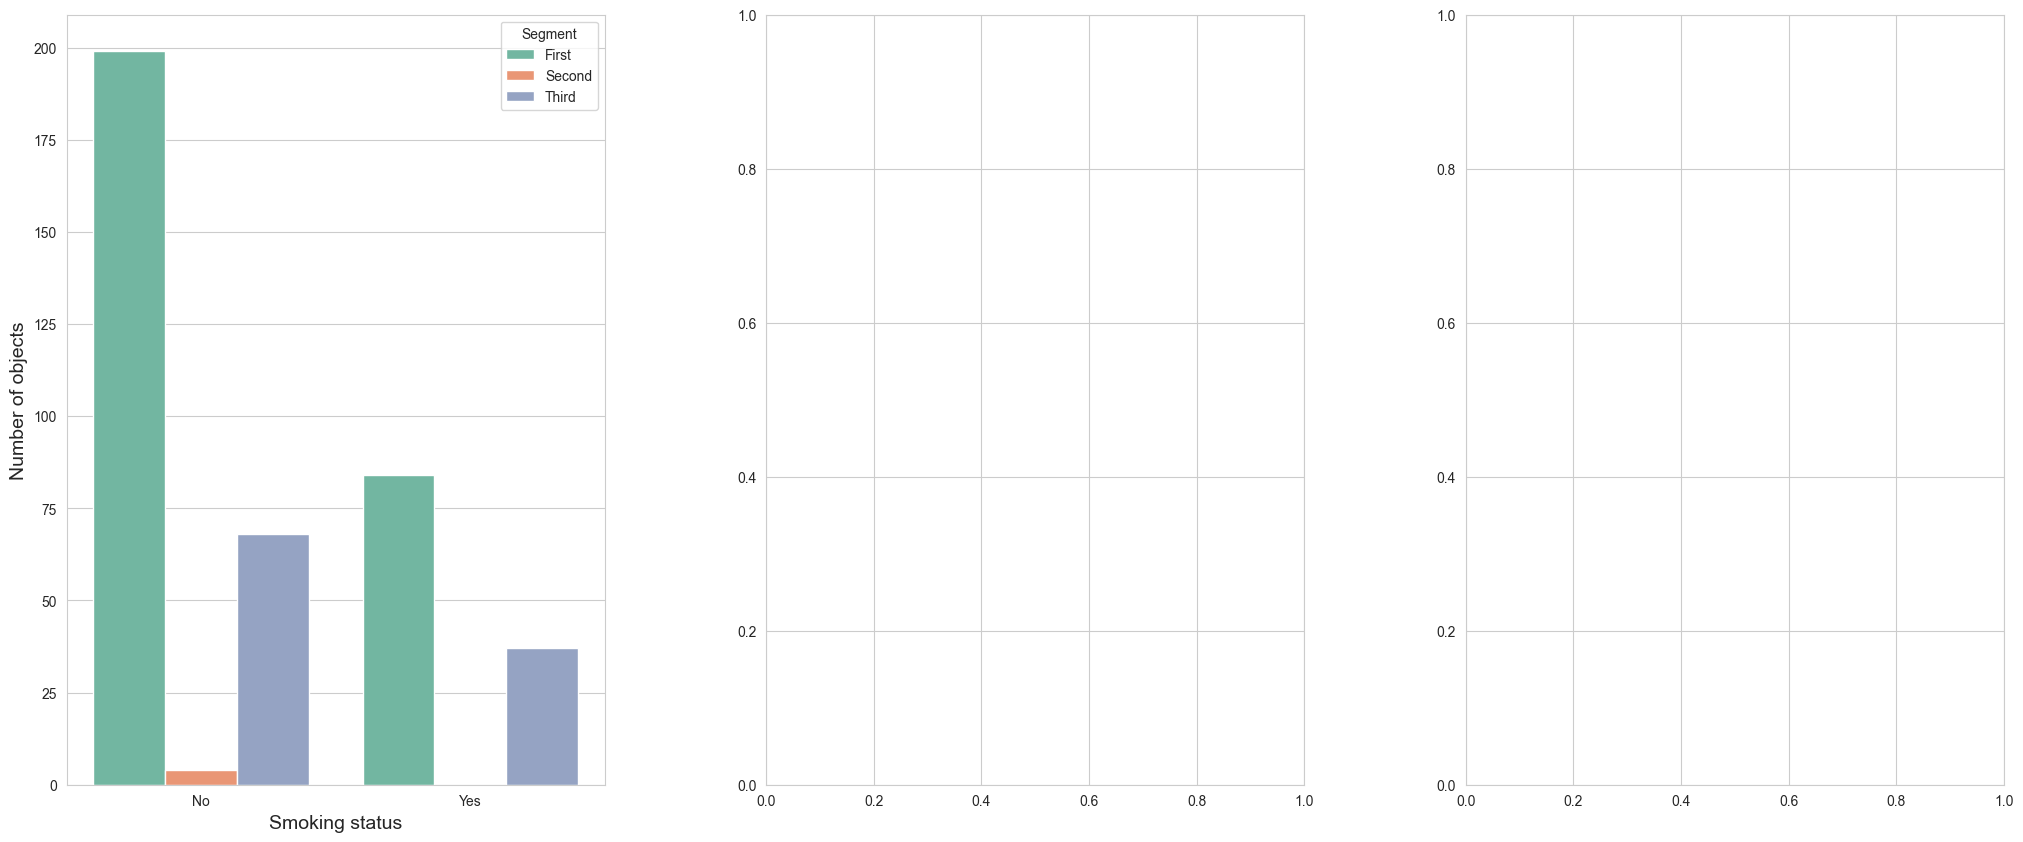

In [47]:
def boxplot():
        n_cols = len(num_cols)
        rows = round(n_cols / 3)
        _, axes = plt.subplots(ncols=3, nrows=rows, figsize=(25, 5 * rows))
        plt.subplots_adjust(wspace=0.3, hspace=0.4)
        for num, col in enumerate(num_cols):
            b = sns.boxplot(
                 data=df1,
                 y=col,
                 x="Segment",
                 palette="Set2",
                 ax=axes.reshape(-1)[num])
            b.set_xlabel('Clusters', fontsize=14)
            b.set_ylabel(f'{df1[col].name}', fontsize=14)
            sns.set_style("whitegrid")



            
def barplot():
        n_cols = len(object_cols)
        rows = n_cols // 3 + n_cols % 3
        size_cluster = df1.groupby("Segment").count().iloc[:, 0]
        _, axes = plt.subplots(ncols=3, nrows=rows, figsize=(25, 10 * rows))
        plt.subplots_adjust(wspace=0.3, hspace=0.4)    
        for num, col in enumerate(object_cols):
            data = (df1.groupby(["Segment"])[col].value_counts().unstack(fill_value=0).T)
            data = pd.DataFrame(data.unstack())
            data.columns = ["Number of objects"]
            data = data.reset_index()
            b= sns.barplot(
                 data=data,
                 x=data[col],
                 hue='Segment',palette="Set2",
                y=data['Number of objects'],
                 ax=axes.reshape(-1)[num])
            b.set_xlabel(f'{data[col].name}', fontsize=14)
            b.set_ylabel('Number of objects', fontsize=14)
            sns.set_style("whitegrid")

boxplot()
barplot()

### Segmentation of clusters

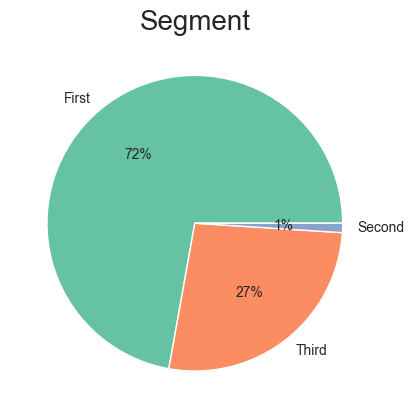

In [48]:
###the propoertion of clusters
plt.title('Segment', fontsize=20)
data = list(df1['Segment'].value_counts().values)
labels = list(df1['Segment'].value_counts().index)
sns_colors = sns.color_palette("Set2")
plt.pie(data, labels = labels, colors= sns_colors,autopct='%.0f%%')
plt.show()

## Cluster Analysis
### Cluster 0: Observations with high incomes and high spending habits that tend to have one child. We will call this group poor sleep quality.
### Cluster 1: Observations with the highest sleep efficiency　，the lowest awarkening time ，early bedtime and wake up habits. We will call this group good sleep quality.
### Cluster 2: Observations with ７awarkening time and low spending habits that also have the lowest time enrolled as a member. We will call this group average sleep quality.